# Import Library

In [1]:
import numpy as np
import tensorflow as tf
# from keras.utils import np_utils
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import itertools
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Split data for Deep Learning purpose

In [2]:
data_dir ='./rumah_adat/'

In [4]:
import splitfolders

# Split with a ratio.
splitfolders.ratio("./rumah_adat/", output="./splited_data",
    seed=1337, ratio=(.55, .05, .4), group_prefix=None, move=False) # default values

Copying files: 3919 files [00:05, 678.73 files/s]


In [5]:
# splitted data dir
train_directory = "./splited_data/train/"
valid_directory = "./splited_data/val/"
test_directory  = "./splited_data/test/"

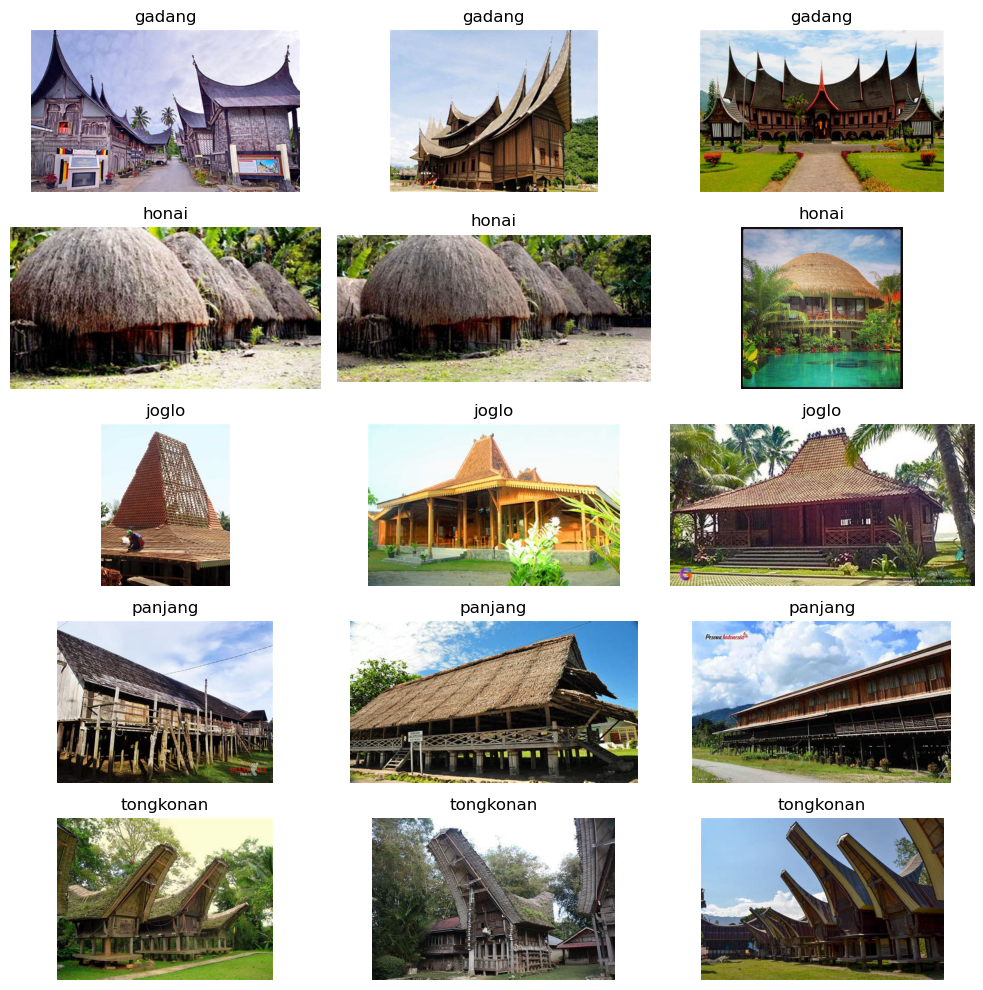

In [6]:
categories = os.listdir(train_directory)

# Set up subplots
num_categories = len(categories)
num_images_per_category = 3
fig, axes = plt.subplots(num_categories, num_images_per_category, figsize=(10, 10))

for i, category in enumerate(categories):
    category_path = os.path.join(train_directory, category)
    image_names = os.listdir(category_path)[:num_images_per_category]  # Get the first 3 images in the category
    
    for j, image_name in enumerate(image_names):
        image_path = os.path.join(category_path, image_name)
        img = plt.imread(image_path)

        # Plot images in subplots
        axes[i, j].imshow(img)
        axes[i, j].set_title(category)
        axes[i, j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

# Utils

In [7]:
# Function for plotting the Confusion Matrix
def plotConfusionMatrix(cm, class_names, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.figure(figsize=(8,8))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      cm = np.around(cm, decimals=2)
      cm[np.isnan(cm)] = 0.0
      print("Normalized confusion matrix")

  else:
      print('Confusion matrix, without normalization')

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

# MACHINE LEARNING

## Data Preprocessing

In [8]:
# feature extraction using HOG

def extract_features(image_path):
    img = cv2.imread(image_path)
    resized_img = cv2.resize(img, (128, 128))  # Resize the image to a fixed size
    gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    hog_features = hog(gray_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True)
    hog_features = np.array(hog_features)
    return hog_features

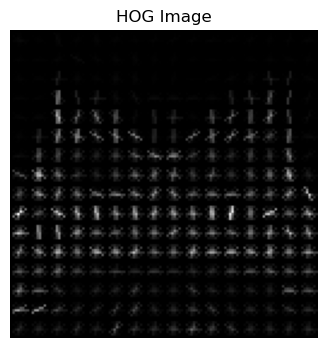

In [13]:
image_path = './splited_data/train/gadang/d-1.png'  # Replace this with your image path
def extract_features(image_path):
    img = cv2.imread(image_path)
    resized_img = cv2.resize(img, (128, 128))
    gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    hog_features, hog_image = hog(
        gray_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, visualize=True
    )
    return hog_features, hog_image

hog_features, hog_image = extract_features(image_path)

# Display the HOG image
plt.figure(figsize=(8, 4))
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Image')
plt.axis('off')
plt.show()

In [8]:
#extract all image and the label

X, y = [], []
categories = os.listdir(data_dir)
for i, category in enumerate(categories):
    category_path = os.path.join(data_dir, category)
    image_names = os.listdir(category_path)
    for image_name in image_names:
        img_path = os.path.join(category_path, image_name)
        features = extract_features(img_path)
        X.append(features)
        y.append(i)

In [10]:
X = np.array(X)
y = np.array(y)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((3135, 8100), (784, 8100))

## Machine Learning Classic Support Vector Machine (SVM)

### SVM with One vs One

In [11]:
# Train SVM classifier
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)


SVC(kernel='linear')

In [12]:
# Predict on test set
y_pred_svm = svm.predict(X_test)

Accuracy: 0.8660714285714286
Confusion matrix, without normalization


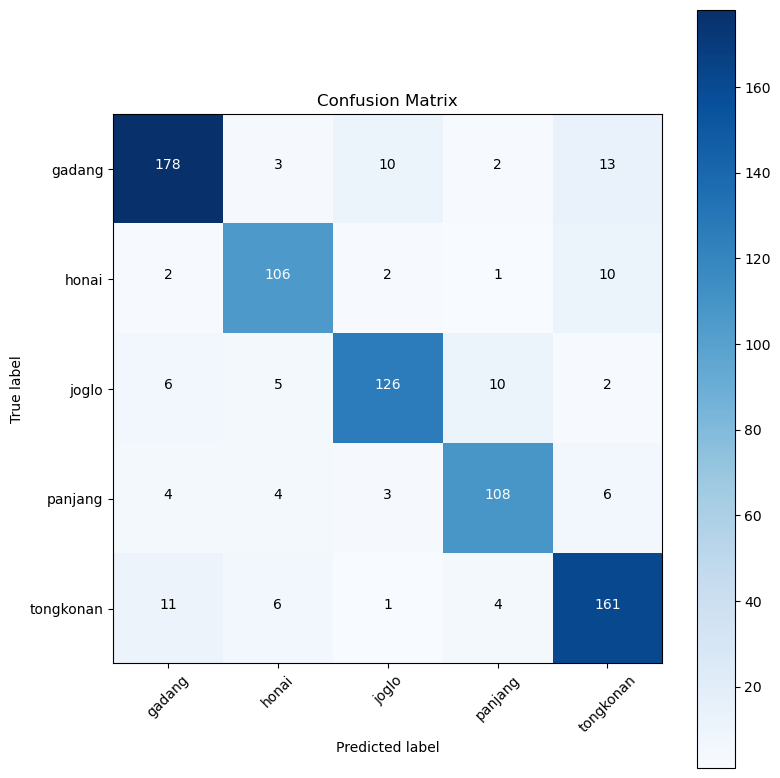

Normalized confusion matrix


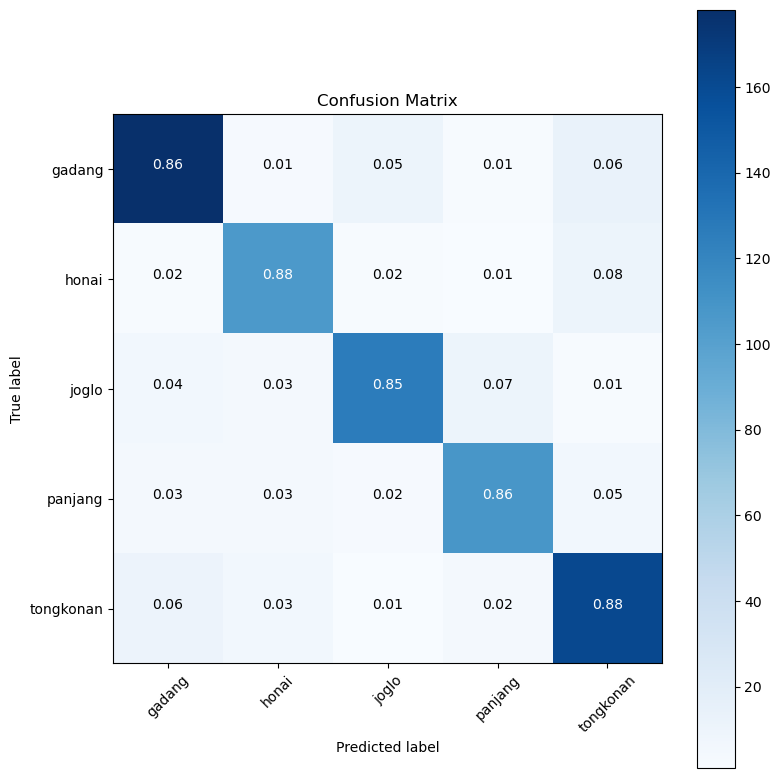

In [15]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy: {accuracy}")

cm_ovo = confusion_matrix(y_test, y_pred_svm)
plotConfusionMatrix(cm_ovo, categories, normalize=False, title='Confusion Matrix')
plotConfusionMatrix(cm_ovo, categories, normalize=True, title='Confusion Matrix')

### SVM with One vs Rest

In [16]:
%%time
from sklearn.multiclass import OneVsRestClassifier
# Train SVM classifier
ovr = OneVsRestClassifier(SVC())
ovr.fit(X_train, y_train)

CPU times: total: 1min 13s
Wall time: 1min 23s


OneVsRestClassifier(estimator=SVC())

In [17]:
y_pred_ovr = ovr.predict(X_test)


Accuracy: 0.9056122448979592
Confusion matrix, without normalization


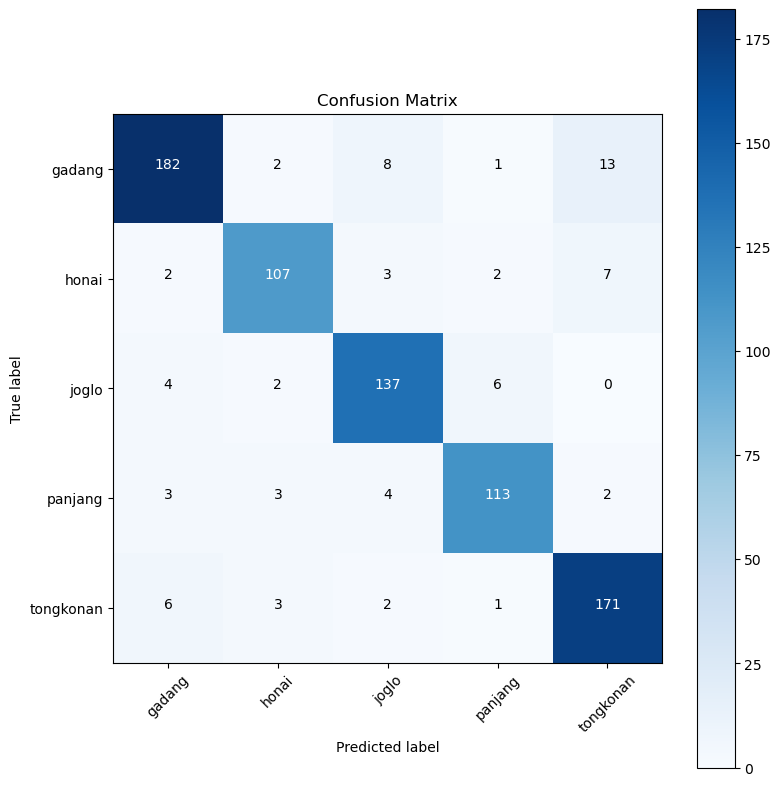

Normalized confusion matrix


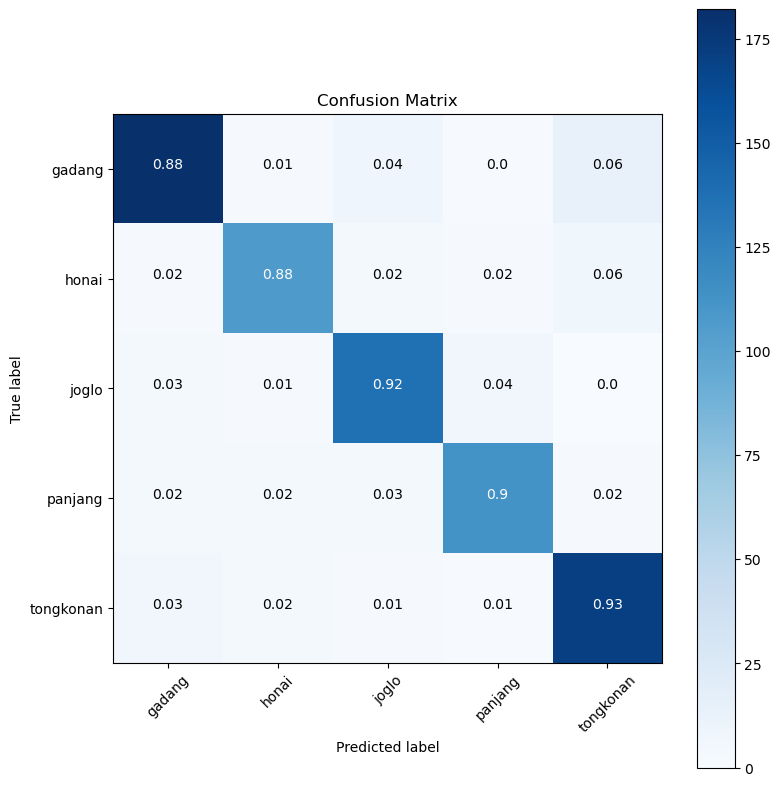

In [18]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_ovr)
print(f"Accuracy: {accuracy}")

cm_ovr = confusion_matrix(y_test, y_pred_ovr)
plotConfusionMatrix(cm_ovr, categories, normalize=False, title='Confusion Matrix')
plotConfusionMatrix(cm_ovr, categories, normalize=True, title='Confusion Matrix')

### Evaluation

In [19]:
from sklearn.metrics import confusion_matrix
from statsmodels.stats.contingency_tables import mcnemar

cont_table = [[(cm_ovo[0, 1]), (cm_ovo[1, 0])],
              [(cm_ovr[0, 1]), (cm_ovr[1, 0])]]

# Perform McNemar's test
result = mcnemar((y_pred_ovr, y_pred_svm), exact=True)

print("McNemar's test statistic:", result.statistic)
print("p-value:", result.pvalue)


McNemar's test statistic: 0.0
p-value: 0.5


In [20]:
from scipy.stats import wilcoxon
statistic, p_value = wilcoxon(y_pred_svm, y_pred_ovr)

print("\nWilcoxon Signed-Rank Test statistic:", statistic)
print("p-value:", p_value)


Wilcoxon Signed-Rank Test statistic: 1015.0
p-value: 0.43142317201136937


In [22]:
print("Using SVM: \n",classification_report(y_test, y_pred_svm))
print("Using SVM + One vs Rest: \n",classification_report(y_test, y_pred_ovr))

Using SVM: 
               precision    recall  f1-score   support

           0       0.89      0.86      0.87       206
           1       0.85      0.88      0.87       121
           2       0.89      0.85      0.87       149
           3       0.86      0.86      0.86       125
           4       0.84      0.88      0.86       183

    accuracy                           0.87       784
   macro avg       0.87      0.87      0.87       784
weighted avg       0.87      0.87      0.87       784

Using SVM + One vs Rest: 
               precision    recall  f1-score   support

           0       0.92      0.88      0.90       206
           1       0.91      0.88      0.90       121
           2       0.89      0.92      0.90       149
           3       0.92      0.90      0.91       125
           4       0.89      0.93      0.91       183

    accuracy                           0.91       784
   macro avg       0.91      0.91      0.91       784
weighted avg       0.91      0.91    

# DEEP LEARNING

In [9]:
# Constants
img_rows = 224
img_cols = 224
input_shape = (img_rows, img_cols, 3)
epochs = 10
batch_size = 32
num_of_classes = 5

# do data augmentation for train and valid images
train_gen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest'
)
test_gen = ImageDataGenerator(rescale=1./255)

# Load Train, Valid, Test Data as image generator with Keras, Normalization with (rescale=1./255)
train_generator = train_gen.flow_from_directory(directory=train_directory,
                                        class_mode='categorical',
                                        batch_size=batch_size,
                                        target_size=(img_rows, img_cols),
                                        color_mode="rgb",
                                        shuffle=True)

valid_generator = train_gen.flow_from_directory(directory=valid_directory,
                                        class_mode='categorical',
                                        batch_size=batch_size,
                                        target_size=(img_rows, img_cols),
                                        color_mode="rgb",
                                        shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_directory,
                                        class_mode='categorical',
                                        batch_size=batch_size,
                                        target_size=(img_rows, img_cols),
                                        color_mode="rgb",
                                        shuffle=False)



Found 2155 images belonging to 5 classes.
Found 195 images belonging to 5 classes.
Found 1569 images belonging to 5 classes.


In [10]:
num_of_train_samples = 2155
num_of_valid_samples = 195
num_of_test_samples = 1569

Example of augmented data

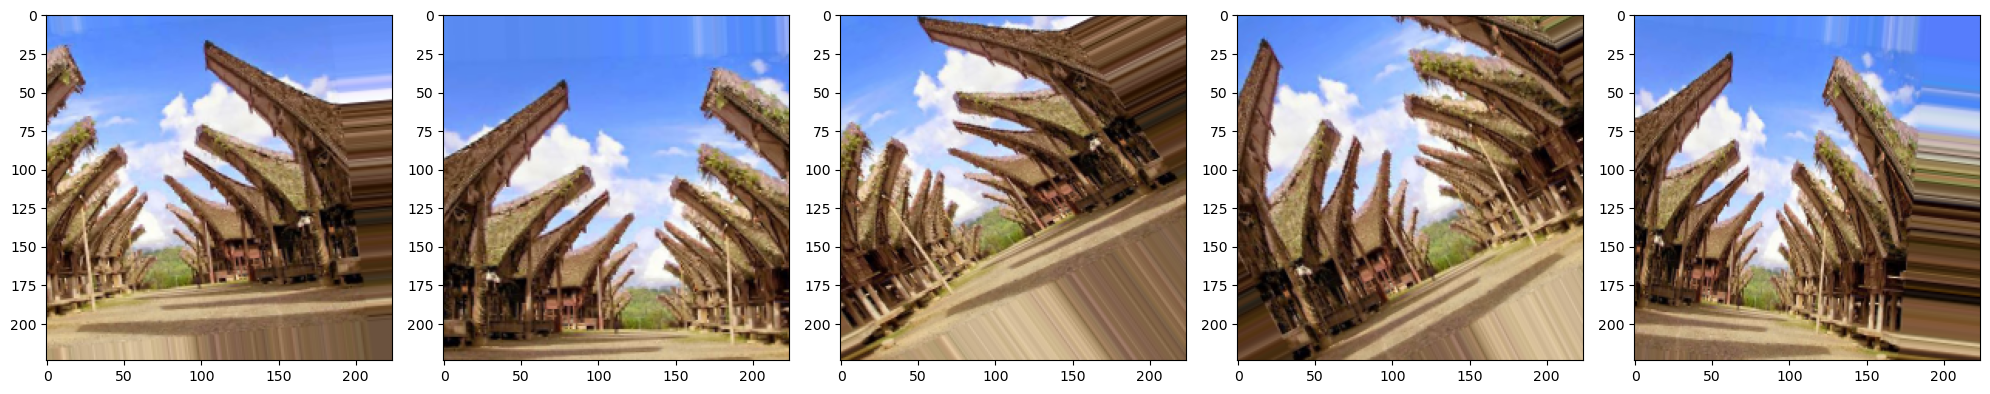

In [11]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(images_arr=augmented_images)

## CNN MODEL

### Model Preparation

In [12]:
def getCNNModel(num_of_layers=2, num_of_filters=32, filter_size=(3, 3), initializer='glorot_uniform', activation_function='relu', dropout=0.2, opt='adam'):
  # Create a Sequential
  model = Sequential()

  # Create Convolution layers
  for i in range(0, num_of_layers):
    model.add(Conv2D(num_of_filters, filter_size, kernel_initializer=initializer, activation=activation_function, input_shape=input_shape))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(dropout))

  model.add(Flatten())

  model.add(Dense(512, activation=activation_function, kernel_initializer=initializer))
  model.add(Dense(num_of_classes, activation='softmax'))

  # Compile model
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()

  return model

In [13]:
plot_loss_1 = PlotLossesCallback()
n_steps = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size

# ModelCheckpoint callback - save best weights
def checkpoint(filename):
  return ModelCheckpoint(filepath=f'./model/{filename}.weights.best.hdf5', save_best_only=True, verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

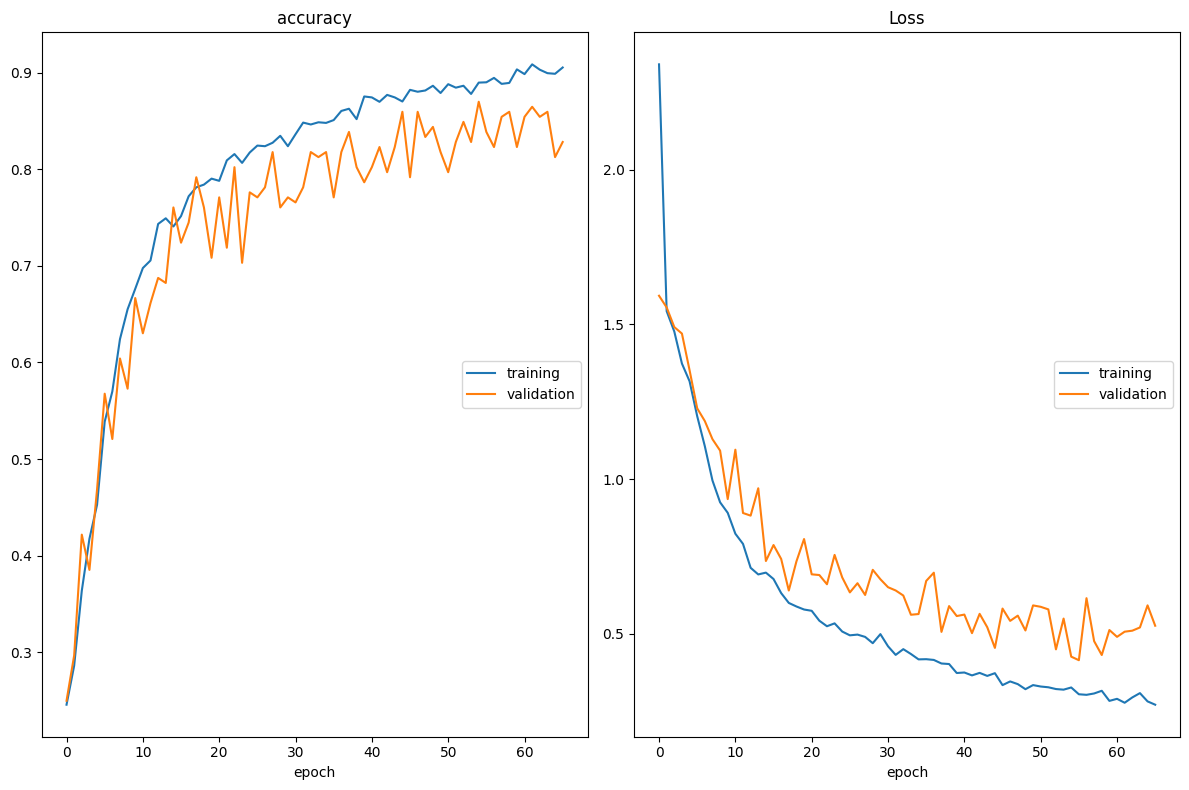

accuracy
	training         	 (min:    0.246, max:    0.908, cur:    0.905)
	validation       	 (min:    0.250, max:    0.870, cur:    0.828)
Loss
	training         	 (min:    0.271, max:    2.340, cur:    0.271)
	validation       	 (min:    0.415, max:    1.592, cur:    0.526)
48/48 [==============================] - 44s 918ms/step - loss: 0.2707 - accuracy: 0.9052 - val_loss: 0.5259 - val_accuracy: 0.8281


In [7]:
# Combination 4
model = getCNNModel(num_of_layers=3, num_of_filters=32, filter_size=(3, 3), initializer='glorot_uniform', activation_function='relu', dropout=0.2, opt='adam')

mode_history = model.fit_generator(train_generator,
                            epochs=epochs,
                            validation_data=valid_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[checkpoint('model_4'), early_stop, plot_loss_1],
                            verbose=1)

model.save('./model/model_cnn_6_4.h5')

### Evalutaion of CNN

In [13]:
cnn_1 = getCNNModel(num_of_layers=3, num_of_filters=32, filter_size=(3, 3), initializer='glorot_uniform', activation_function='relu', dropout=0.2, opt='adam')
cnn_1.load_weights('./model/model_4.weights.best.hdf5')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 54, 54, 32)       

2023-11-17 13:22:19.862561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-17 13:22:24.057715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-17 13:22:24.117622: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-17 13:22:24.117705: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10139 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


Test Loss:  0.253109335899353
Test Accuracy:  0.9118643999099731
Confusion matrix, without normalization


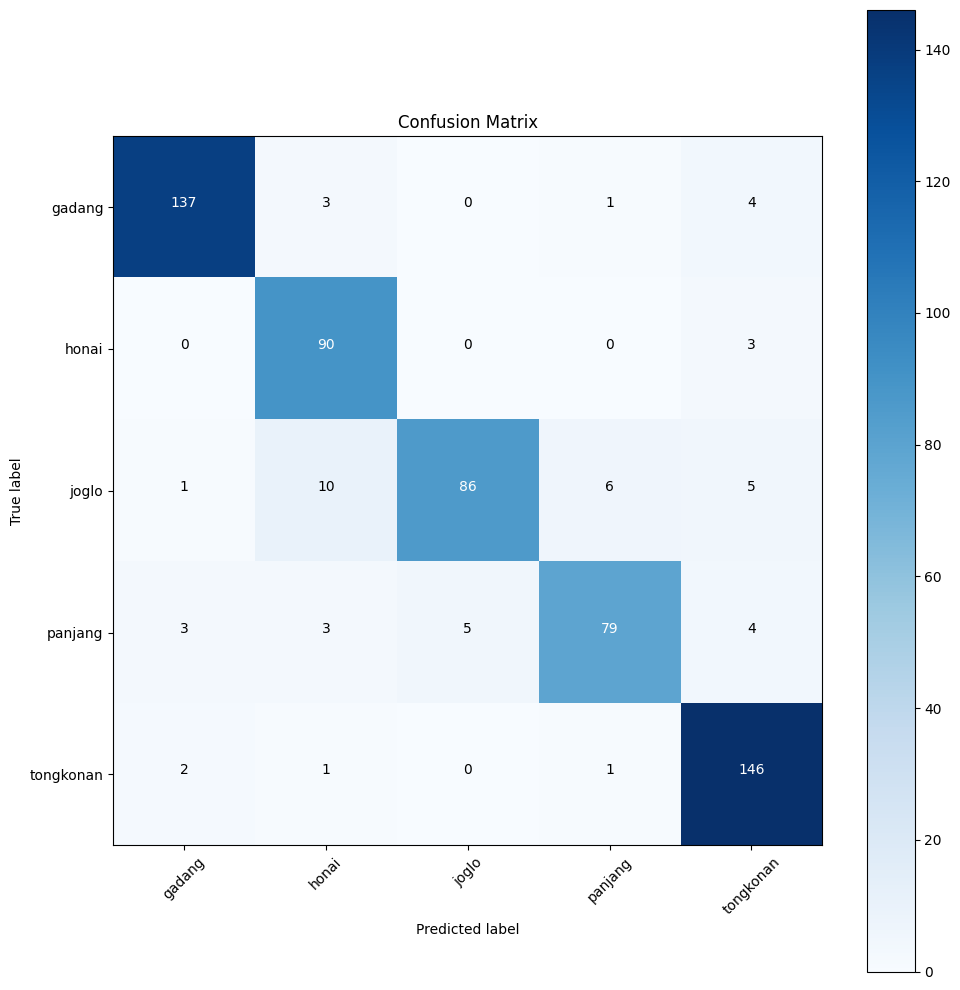

Normalized confusion matrix


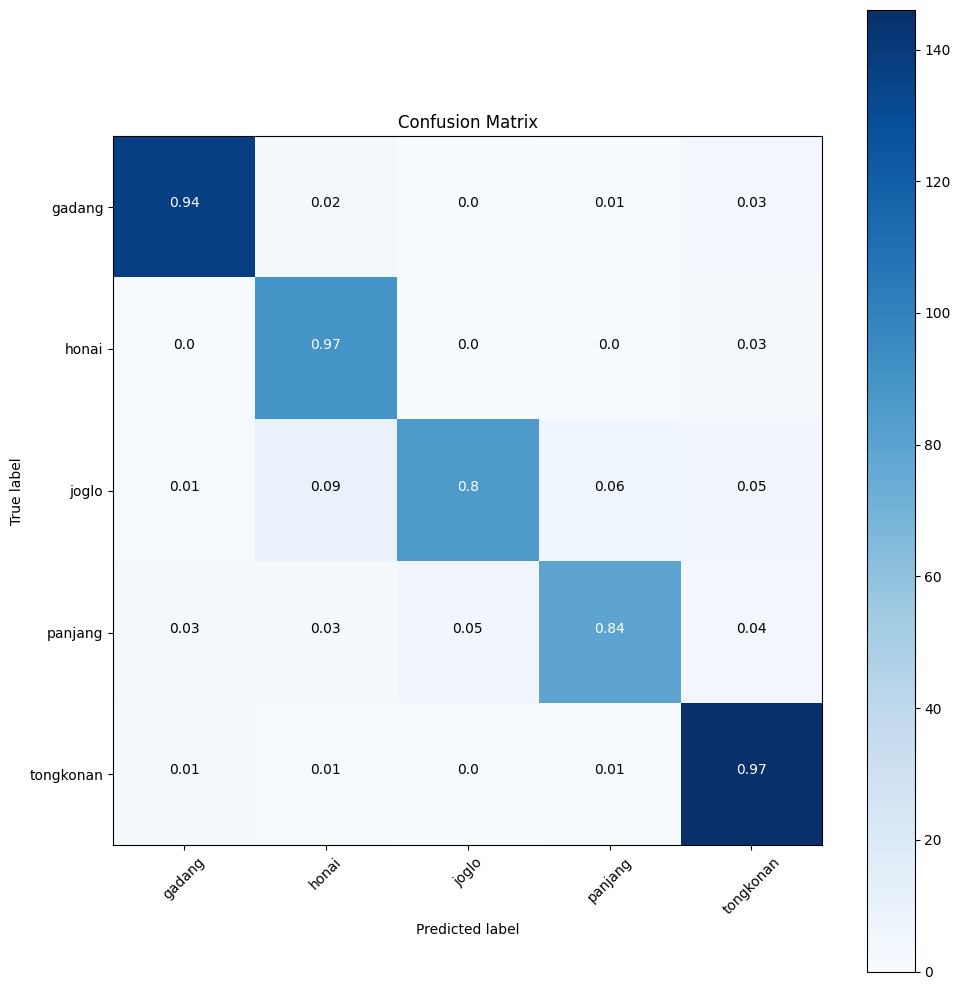

In [14]:
Y_pred = cnn_1.predict_generator(test_generator, steps=num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

# Evaluate the model
loss_and_metrics = cnn_1.evaluate_generator(test_generator, steps=num_of_test_samples // batch_size+1)
print("Test Loss: ", loss_and_metrics[0])
print("Test Accuracy: ", loss_and_metrics[1])
test_generator.reset()


class_names = []
for key in train_generator.class_indices:
    class_names.append(key)
cm = confusion_matrix(test_generator.classes, y_pred)

plotConfusionMatrix(cm, class_names, normalize=False, title='Confusion Matrix')
plotConfusionMatrix(cm, class_names, normalize=True, title='Confusion Matrix')

## VGG-Model

### Model Preparation

In [27]:
def vgg16Model(fine_tune = 0):
  conv_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
  
  if fine_tune > 0:
      for layer in conv_base.layers[:-fine_tune]:
          layer.trainable = False
  else:
      for layer in conv_base.layers:
          layer.trainable = False
  
  top_model = conv_base.output
  top_model = GlobalAveragePooling2D(name="globalAvgPool")(top_model)
  # top_model = Dense(512, activation='relu')(top_model)
  # top_model = Dropout(0.5)(top_model)
  top_model = Dense(256, activation='relu')(top_model)
  top_model = Dropout(0.2)(top_model)
  output_layer = Dense(num_of_classes, activation='softmax')(top_model)
  model = Model(inputs=conv_base.input, outputs=output_layer)

  # optimizer (adam)
  optimizer = Adam(learning_rate=0.001)
  # Compiles the model for training.
  model.compile(optimizer=optimizer, 
                loss='categorical_crossentropy',
                metrics=['accuracy'],
              )
  return model

In [20]:
# define n_steps for training and add callbacks

plot_loss_1 = PlotLossesCallback()
n_steps = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size

# ModelCheckpoint callback - save best weights
def checkpoint(filename):
  return ModelCheckpoint(filepath=f'./model/{filename}.weights.best.hdf5', save_best_only=True, verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=30,
                           restore_best_weights=True,
                           mode='min')

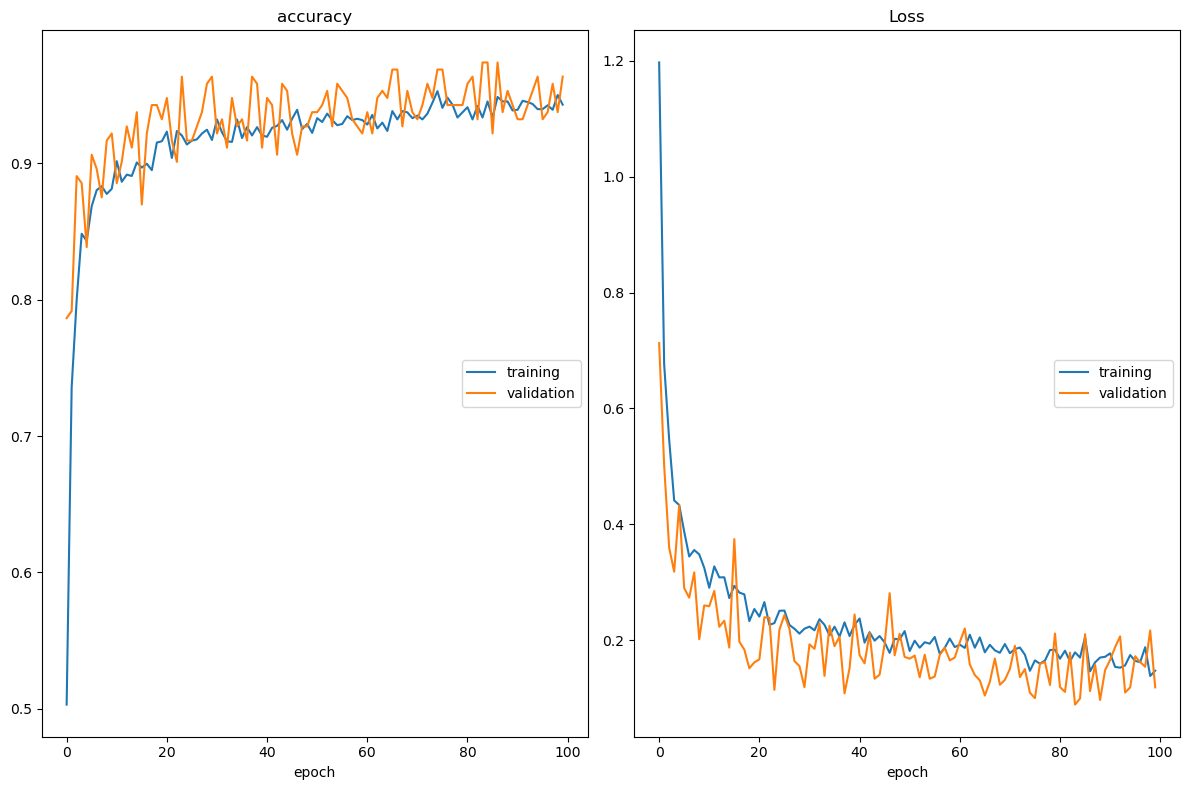

accuracy
	training         	 (min:    0.503, max:    0.953, cur:    0.943)
	validation       	 (min:    0.786, max:    0.974, cur:    0.964)
Loss
	training         	 (min:    0.139, max:    1.197, cur:    0.148)
	validation       	 (min:    0.089, max:    0.713, cur:    0.119)
67/67 [==============================] - 32s 471ms/step - loss: 0.1476 - accuracy: 0.9430 - val_loss: 0.1189 - val_accuracy: 0.9635


In [21]:
# Execute the model
model = vgg16Model()
mode_history = model.fit_generator(train_generator,
                            epochs=100,
                            validation_data=valid_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[checkpoint('model_vgg_6_4'),early_stop, plot_loss_1],
                            verbose=1)

In [24]:
# define n_steps for training and add callbacks

plot_loss_1 = PlotLossesCallback()
n_steps = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size

# ModelCheckpoint callback - save best weights
def checkpoint(filename):
  return ModelCheckpoint(filepath=f'./model/{filename}.weights.best.hdf5', save_best_only=True, verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=30,
                           restore_best_weights=True,
                           mode='max')

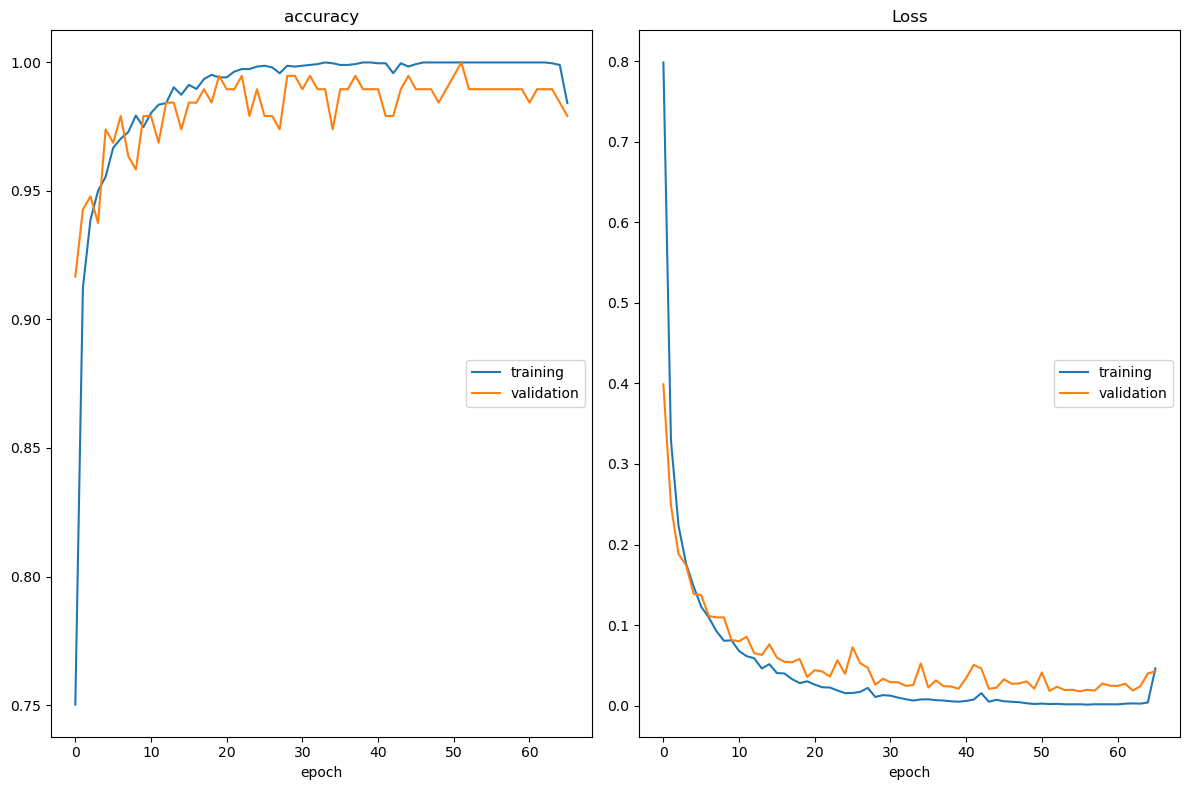

accuracy
	training         	 (min:    0.750, max:    1.000, cur:    0.984)
	validation       	 (min:    0.917, max:    1.000, cur:    0.979)
Loss
	training         	 (min:    0.001, max:    0.799, cur:    0.046)
	validation       	 (min:    0.018, max:    0.399, cur:    0.042)
97/97 [==============================] - 33s 340ms/step - loss: 0.0462 - accuracy: 0.9842 - val_loss: 0.0425 - val_accuracy: 0.9792


In [ ]:
# Execute the model
model = vgg16Model()
mode_history = model.fit_generator(train_generator,
                            epochs=100,
                            validation_data=valid_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[checkpoint('model_vgg_6_4_get_val_acc'),early_stop, plot_loss_1],
                            verbose=1)

### Evaluation of Pretrained Model

In [22]:
model = vgg16Model()
model.load_weights('./model/model_vgg_6_4.weights.best.hdf5')

Test Loss:  0.12769551575183868
Test Accuracy:  0.9585723280906677
Confusion matrix, without normalization


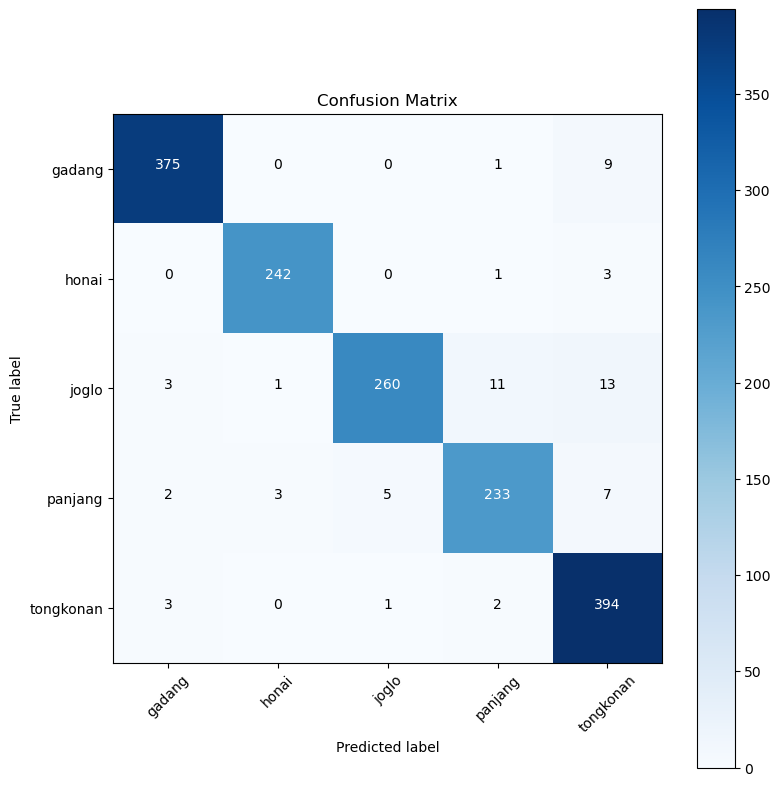

Normalized confusion matrix


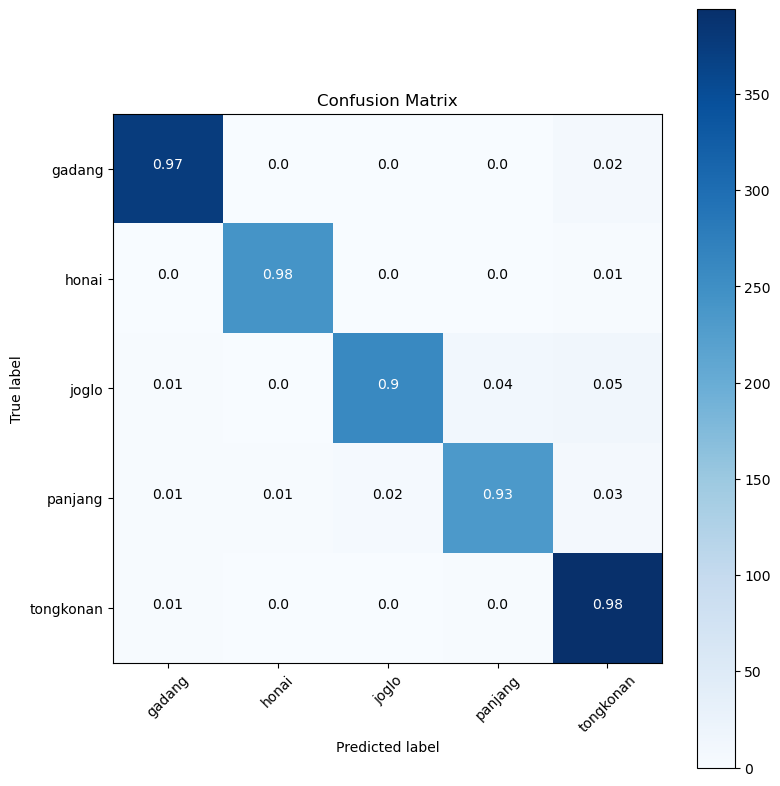

In [23]:
Y_pred = model.predict_generator(test_generator, steps=num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

# Evaluate the model
loss_and_metrics = model.evaluate_generator(test_generator, steps=num_of_test_samples // batch_size+1)
print("Test Loss: ", loss_and_metrics[0])
print("Test Accuracy: ", loss_and_metrics[1])
test_generator.reset()


class_names = []
for key in train_generator.class_indices:
    class_names.append(key)
cm = confusion_matrix(test_generator.classes, y_pred)

plotConfusionMatrix(cm, class_names, normalize=False, title='Confusion Matrix')
plotConfusionMatrix(cm, class_names, normalize=True, title='Confusion Matrix')